# LTFS Model RF tuning 

- RandomizedSearchCV
- Bayesian Optimization

see: https://github.com/kulkarni-vishwanath/LTFS_DataScince_Finhack_2/blob/master/Untitled.ipynb

- TODO: 
    - Ensemble best submissions
    - Explore (plot+hist)

In [0]:
import pandas as pd
import numpy as np
import os
import gc
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split,KFold,cross_val_score,RandomizedSearchCV,TimeSeriesSplit,GridSearchCV, GroupKFold
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.ensemble import RandomForestRegressor

from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

import statsmodels.api as sm
import scipy.stats

import lightgbm as lgb
from lightgbm import LGBMRegressor
import xgboost as xgb
from xgboost import XGBRegressor
# import catboost as cb
# from catboost import Pool, CatBoostRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_selection import RFE, RFECV,VarianceThreshold, chi2
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, Normalizer 

from functools import *
import datetime as dt
import time 

## Helpers

`Ctrl+ Shift + i` to `open` inspector view . Then goto console.

```
function ClickConnect(){
console.log("Working"); 
document.querySelector("colab-toolbar-button#connect").click() 
}
setInterval(ClickConnect,60000)
```

In [2]:
# Mount Gdrive method-1
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# MAPE criterion-1
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mape2(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_pred - y_true) / y_pred)) * 100

## Load data

In [0]:
COLAB = True 

if COLAB:
  data_path = '/content/gdrive/My Drive/ML Projects/AV-LTFS/data/'
  models_path = '/content/gdrive/My Drive/ML Projects/AV-LTFS/models/'
  out_path = '/content/gdrive/My Drive/ML Projects/AV-LTFS/'
else:
  data_path = '/home/ime/Documents/PyCharmProjects/AV/LTFS/data/'
  models_path = '/home/ime/Documents/PyCharmProjects/AV/LTFS/models/'
  out_path = '/home/ime/Documents/PycharmProjects/AV/LTFS/submissions/'

In [0]:
data_train = pd.read_csv(data_path+'LTFS_train.csv', parse_dates=["application_date"])
data_test = pd.read_csv(data_path+'LTFS_test.csv',parse_dates=["application_date"])

subm_file = pd.read_csv(data_path+'LTFS_sample_submission.csv')

In [6]:
print ("Shape of Training Data:{}".format(data_train.shape))
print ("Shape of Testing Data:{}".format(data_test.shape))

Shape of Training Data:(80402, 6)
Shape of Testing Data:(180, 3)


### EDA- Train Data

In [0]:
data_train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80402 entries, 0 to 80401
Data columns (total 6 columns):
application_date    80402 non-null datetime64[ns]
segment             80402 non-null int64
branch_id           66898 non-null float64
state               80402 non-null object
zone                66898 non-null object
case_count          80402 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 11.9 MB


1. There are missing values in branch_id and zone variables.
2. application_date variable is read as datetime type.
3. Dependent variable does not have missing values. 

In [0]:
data_train['application_date'].max(), data_train['application_date'].min()
# Training data starts from 1st of April 2017 and ends at 23rd of July 2019. Roughly 2 years of data.

(Timestamp('2019-07-23 00:00:00'), Timestamp('2017-04-01 00:00:00'))

Text(0, 0.5, 'Count')

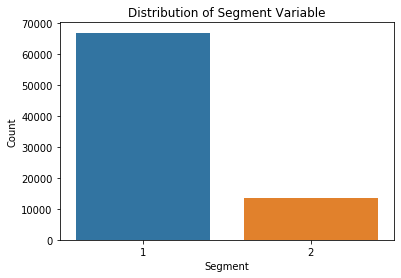

In [0]:
sns.countplot(data_train['segment'],order=data_train['segment'].value_counts().index)
plt.title("Distribution of Segment Variable")
plt.xlabel("Segment")
plt.ylabel("Count")
# Lot more values of Segment1 than Segment2

In [0]:
data_train['branch_id'].value_counts(dropna=False).head(10)
# All of the branch_id's have the same count i.e. 806 and this variable has 13504 missing values.

NaN       13504
 159.0      806
 17.0       806
 67.0       806
 269.0      806
 74.0       806
 268.0      806
 135.0      806
 62.0       806
 271.0      806
Name: branch_id, dtype: int64

In [0]:
print ("Number of Unique Branch_Id's in Training Data:{}".format(data_train['branch_id'].nunique()))
# 83 unique branch_id's in total in training dataset.

Number of Unique Branch_Id's in Training Data:83


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

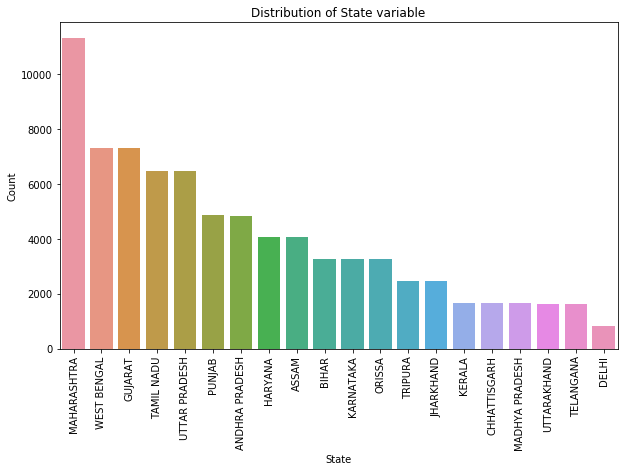

In [0]:
plt.figure(figsize=(10,6))
sns.countplot(data_train['state'],order=data_train['state'].value_counts(dropna=False).index)
plt.title("Distribution of State variable")
plt.xlabel("State")
plt.ylabel("Count")
plt.xticks(rotation=90)
# Maharashtra has the largest count followed by West Bengal and Gujarat, Delhi has the least count.

Text(0, 0.5, 'Count')

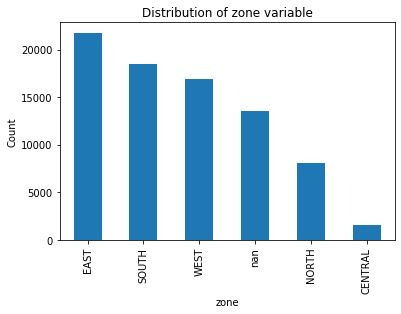

In [0]:
data_train['zone'].value_counts(dropna=False).plot(kind='bar')
plt.title("Distribution of zone variable")
plt.xlabel("zone")
plt.ylabel("Count")
# East has the highest count and Central has the least count, lot of missing values here.

In [0]:
data_train['case_count'].describe()

count    80402.000000
mean       185.481841
std        749.602925
min          0.000000
25%          0.000000
50%         18.000000
75%         60.000000
max      13787.000000
Name: case_count, dtype: float64

Some observations with respect to the dependent variable,
1. Maximum case count is 13787 which is exceptionally high.
2. Minimum case count is 0 which is understandable. 
3. Average value is 185 and the Median value is 18, so the distribution will be somewhat skewed. 

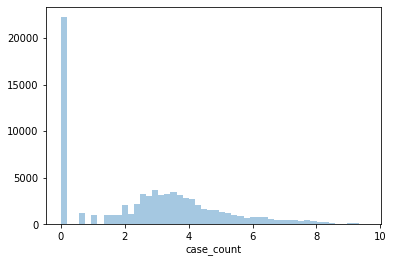

In [0]:
sns.distplot(np.log1p(data_train['case_count']),kde=False,bins=50)
# As we can see a lot of 0 values. 

In [0]:
data_train.head()

,application_date,segment,branch_id,state,zone,case_count
0,2017-04-01,1,1.0,WEST BENGAL,EAST,40.0
1,2017-04-03,1,1.0,WEST BENGAL,EAST,5.0
2,2017-04-04,1,1.0,WEST BENGAL,EAST,4.0
3,2017-04-05,1,1.0,WEST BENGAL,EAST,113.0
4,2017-04-07,1,1.0,WEST BENGAL,EAST,76.0


### Bi-Variate Analysis

In [0]:
data_train.groupby('segment')['case_count'].agg(['min','max','mean','median','std'])
# We can see that the Maximum value of case_count belongs to segment 2. 
# all these values for segment1 are higher than segment2.

,min,max,mean,median,std
segment,,,,,
1,0.0,1890.0,32.707106,14.0,61.591868
2,0.0,13787.0,942.318646,371.0,1624.339623


In [0]:
data_train.groupby('state')['case_count'].agg(['count','min','max','mean','median','std','sum']).sort_values(by='count')
# Although the count of Maharashtra is maximum, the sum of all case counts is maximum for Tamil Nadu.

,count,min,max,mean,median,std,sum
state,,,,,,,
DELHI,806,0.0,1488.0,168.486352,136.0,148.757794,135800.0
UTTARAKHAND,1612,0.0,383.0,24.782258,20.0,27.525605,39949.0
TELANGANA,1612,0.0,1038.0,56.153226,0.0,88.913544,90519.0
KERALA,1650,0.0,3369.0,496.008485,39.5,722.016808,818414.0
CHHATTISGARH,1650,0.0,1111.0,181.298788,22.5,241.012685,299143.0
MADHYA PRADESH,1650,0.0,2350.0,348.672121,87.0,455.859267,575309.0
TRIPURA,2456,0.0,997.0,82.313111,32.0,142.665541,202161.0
JHARKHAND,2456,0.0,833.0,69.036645,20.0,137.794878,169554.0
BIHAR,3262,0.0,7691.0,419.025445,25.0,1111.541528,1366861.0


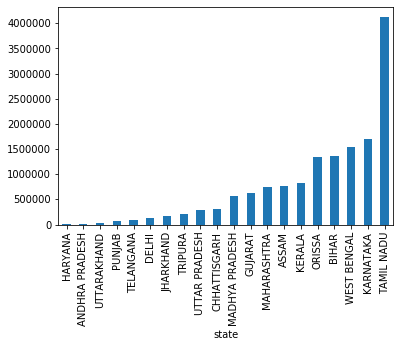

In [0]:
data_train.groupby('state')['case_count'].sum().sort_values().plot(kind='bar')

In [0]:
data_train.groupby('zone')['case_count'].agg(['count','min','max','mean','median','std','sum']).sort_values(by='count')
# Even here, although the count of East zone is maximum, but the total case_counts received in West zone is highest.

,count,min,max,mean,median,std,sum
zone,,,,,,,
CENTRAL,1612,0.0,609.0,23.082506,11.0,36.657118,37209.0
NORTH,8060,0.0,1488.0,27.383002,6.0,69.671582,220707.0
WEST,16926,0.0,1890.0,46.985053,23.0,77.373460,795269.0
SOUTH,18538,0.0,1143.0,26.973784,8.0,54.089844,500040.0
EAST,21762,0.0,1657.0,29.170802,16.0,48.989433,634815.0


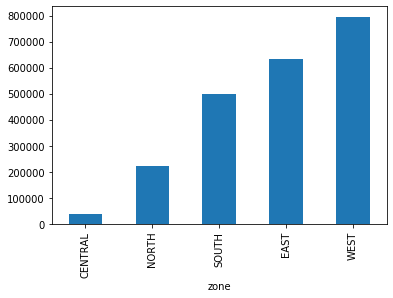

In [0]:
data_train.groupby('zone')['case_count'].sum().sort_values().plot(kind='bar')

In [0]:
# # Let's create some additional datetime based features
# data_train['year'] = data_train.application_date.dt.year
# data_train['month'] = data_train.application_date.dt.month
# data_train['dayofweek'] = data_train.application_date.dt.dayofweek
# data_train['day'] = data_train.application_date.dt.day
# data_train['quarter'] = data_train.application_date.dt.quarter
# data_train['is_month_start'] = data_train.application_date.dt.is_month_start
# data_train['is_month_end'] = data_train.application_date.dt.is_month_end
# data_train['is_quarter_start'] = data_train.application_date.dt.is_quarter_start
# data_train['is_quarter_end'] = data_train.application_date.dt.is_quarter_end

In [0]:
train.head()

,application_date,segment,branch_id,state,zone,case_count,year,month,dayofweek,day,quarter,is_month_start,is_month_end,is_quarter_start,is_quarter_end
0,2017-04-01,1,1.0,WEST BENGAL,EAST,40.0,2017,4,5,1,2,True,False,True,False
1,2017-04-03,1,1.0,WEST BENGAL,EAST,5.0,2017,4,0,3,2,False,False,False,False
2,2017-04-04,1,1.0,WEST BENGAL,EAST,4.0,2017,4,1,4,2,False,False,False,False
3,2017-04-05,1,1.0,WEST BENGAL,EAST,113.0,2017,4,2,5,2,False,False,False,False
4,2017-04-07,1,1.0,WEST BENGAL,EAST,76.0,2017,4,4,7,2,False,False,False,False


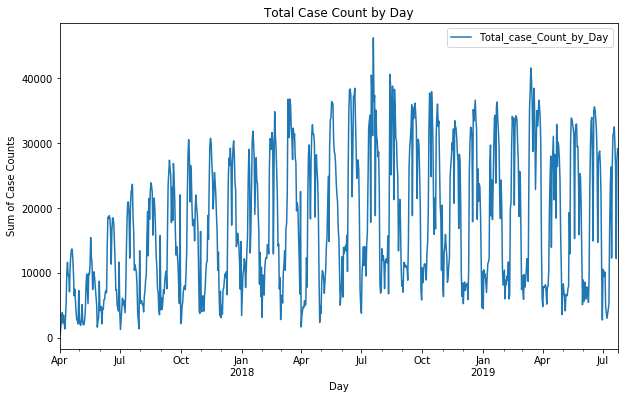

In [0]:
data_train.set_index('application_date').resample('D')['case_count'].sum().plot(kind='line',figsize=(10,6),label='Total_case_Count_by_Day')
plt.title("Total Case Count by Day")
plt.xlabel('Day')
plt.ylabel("Sum of Case Counts")
plt.legend(loc='best')

- We can see some kind of trend here, the sum total of case counts increases for sometime and then stays almost same. 
- We can also see a spike that is apart from the trend around July-Oct of 2018.

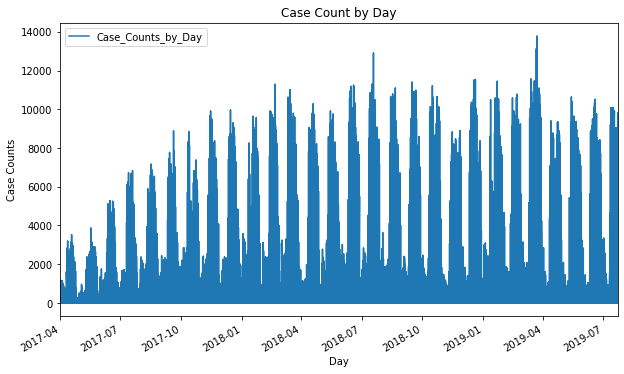

In [0]:
data_train.set_index('application_date')['case_count'].plot(kind='line',figsize=(10,6),label='Case_Counts_by_Day')
plt.title("Case Count by Day")
plt.xlabel('Day')
plt.ylabel("Case Counts")
plt.legend(loc='best')

- We can see increasing and decreasing trends here

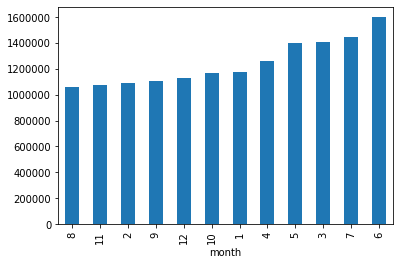

In [0]:
data_train.groupby('month')['case_count'].sum().sort_values().plot(kind='bar')

- case_count sum is maximum during the month of June followed by July, March and May which are close to each other. 
- It is minimum in August.

In [0]:
data_train.groupby('dayofweek')['case_count'].agg(['count','min','max','sum','mean']).sort_values(by='count')

,count,min,max,sum,mean
dayofweek,,,,,
6,11149,0.0,10250.0,1436647.0,128.858821
5,11398,0.0,13787.0,2135403.0,187.348921
2,11548,0.0,11160.0,2314316.0,200.408382
4,11548,0.0,13118.0,2262137.0,195.889938
0,11564,0.0,10805.0,2173422.0,187.947250
1,11564,0.0,11506.0,2280995.0,197.249654
3,11631,0.0,12908.0,2310191.0,198.623592


- Thursday has the highest occurence and Sunday has the least. 
- Wednesday has the highest sum total of case counts.

In [0]:
data_train.groupby(['year','quarter'])['case_count'].agg(['count','min','max','sum','mean'])

count  min      max        sum        mean
year quarter                                            
2017 2         8428  0.0   5274.0   706232.0   83.795918
     3         8361  0.0   8884.0  1197941.0  143.277240
     4         9108  0.0   9963.0  1449814.0  159.180281
2018 1         8578  0.0  11288.0  1728408.0  201.493122
     2         9009  0.0  11241.0  1812629.0  201.202020
     3         9108  0.0  12908.0  2027253.0  222.579381
     4         9108  0.0  11536.0  1919816.0  210.783487
2019 1         8910  0.0  13787.0  1944961.0  218.289675
     2         9009  0.0  10629.0  1734401.0  192.518704
     3          783  0.0  10099.0   391656.0  500.199234

- Count is maximum during the 4th Quarter of 2017 and 3rd and 4th quarter of 2018.
- Sum is maximum during 3rd quarter of 2017.

In [0]:
data_train.head()

,application_date,segment,branch_id,state,zone,case_count,year,month,dayofweek,day,quarter,is_month_start,is_month_end,is_quarter_start,is_quarter_end
0,2017-04-01,1,1.0,WEST BENGAL,EAST,40.0,2017,4,5,1,2,True,False,True,False
1,2017-04-03,1,1.0,WEST BENGAL,EAST,5.0,2017,4,0,3,2,False,False,False,False
2,2017-04-04,1,1.0,WEST BENGAL,EAST,4.0,2017,4,1,4,2,False,False,False,False
3,2017-04-05,1,1.0,WEST BENGAL,EAST,113.0,2017,4,2,5,2,False,False,False,False
4,2017-04-07,1,1.0,WEST BENGAL,EAST,76.0,2017,4,4,7,2,False,False,False,False


## Process Train data

In [7]:
df_train = data_train.groupby(['application_date','segment'], as_index=False)['case_count'].sum()

print(df_train.shape)
df_train.head()

(1650, 3)


,application_date,segment,case_count
0,2017-04-01,1,299.0
1,2017-04-01,2,897.0
2,2017-04-02,2,605.0
3,2017-04-03,1,42.0
4,2017-04-03,2,2016.0


In [0]:
holidays = ['2017-04-05','2017-04-09','2017-04-14','2017-05-01',
       '2017-05-10', '2017-06-25', '2017-06-26', '2017-08-07',
       '2017-08-14', '2017-08-15', '2017-08-25', '2017-09-02',
       '2017-09-04', '2017-09-30', '2017-10-01', '2017-10-02',
       '2017-10-19', '2017-12-01', '2017-12-25', '2018-01-01', 
       '2018-01-14', '2018-01-22', '2018-01-26',
       '2018-01-31', '2018-02-10', '2018-02-14', '2018-02-19',
       '2018-03-01', '2018-03-02', '2018-03-18', '2018-03-25',
       '2018-03-29', '2018-03-30', '2018-04-01', '2018-04-14',
       '2018-04-15', '2018-04-30', '2018-05-09', '2018-06-15',
       '2018-06-16', '2018-07-14', '2018-08-15', '2018-08-17',
       '2018-08-22', '2018-08-25', '2018-08-26', '2018-09-03',
       '2018-09-13', '2018-09-21', '2018-10-02', '2018-10-16',
       '2018-10-17', '2018-10-18', '2018-10-19', '2018-10-24',
       '2018-10-27', '2018-11-06', '2018-11-07', '2018-11-08',
       '2018-11-09', '2018-11-13', '2018-11-21', '2018-11-23',
       '2018-11-24', '2018-12-24', '2018-12-25', '2019-01-01',
       '2019-01-13', '2019-01-14', '2019-01-15', '2019-01-26',
       '2019-02-10', '2019-02-19', '2019-03-01', '2019-03-04',
       '2019-03-20', '2019-03-21', '2019-04-06', '2019-04-13',
       '2019-04-14', '2019-04-15', '2019-04-17', '2019-04-19',
       '2019-04-21', '2019-05-09', '2019-05-18', '2019-05-31',
       '2019-06-05', '2019-07-04', '2019-08-12', '2019-08-15',
       '2019-08-17', '2019-08-24', '2019-09-02', '2019-09-10',
       '2019-09-11', '2019-10-02', '2019-10-05', '2019-10-06',
       '2019-10-07', '2019-10-08', '2019-10-13', '2019-10-17',
       '2019-10-27', '2019-10-28', '2019-10-29', '2019-11-02',
       '2019-11-10', '2019-11-12', '2019-11-24', '2019-12-24',
       '2019-12-25']

In [0]:
# Data processing functions

# function to create a weekend indicator
def weekend_ind(x):
    if (x>4 and x<=6):
        return True
    else:
        return False

def process_date_data(df):
    df['year'] = df.application_date.dt.year
    df['month'] = df.application_date.dt.month
    df['dayofweek'] = df.application_date.dt.dayofweek
    df['day'] = df.application_date.dt.day
    df['quarter'] = df.application_date.dt.quarter
    df['is_month_start'] = df.application_date.dt.is_month_start
    df['is_month_start'] = df['is_month_start'].astype(int)
    df['is_month_end'] = df.application_date.dt.is_month_end
    df['is_month_end'] = df['is_month_end'].astype(int)
    df['is_quarter_start'] = df.application_date.dt.is_quarter_start
    df['is_quarter_start'] = df['is_quarter_start'].astype(np.int)
    df['is_quarter_end'] = df.application_date.dt.is_quarter_end
    df['is_quarter_end'] = df['is_quarter_end'].astype(np.int)
    
    # v2. add weekend and holidays
    df['weekend'] = df['dayofweek'].apply(weekend_ind)
    df['weekend'] = df['weekend'].astype(np.int)
    df['is_holiday'] = (df.application_date.dt.date.astype("str").isin(holidays)).astype(int)

    return df

In [10]:
process_date_data(df_train)

,application_date,segment,case_count,year,month,dayofweek,day,quarter,is_month_start,is_month_end,is_quarter_start,is_quarter_end,weekend,is_holiday
0,2017-04-01,1,299.0,2017,4,5,1,2,1,0,1,0,1,0
1,2017-04-01,2,897.0,2017,4,5,1,2,1,0,1,0,1,0
2,2017-04-02,2,605.0,2017,4,6,2,2,0,0,0,0,1,0
3,2017-04-03,1,42.0,2017,4,0,3,2,0,0,0,0,0,0
4,2017-04-03,2,2016.0,2017,4,0,3,2,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1645,2019-07-19,2,29778.0,2019,7,4,19,3,0,0,0,0,0,0
1646,2019-07-20,2,26123.0,2019,7,5,20,3,0,0,0,0,1,0
1647,2019-07-21,2,12267.0,2019,7,6,21,3,0,0,0,0,1,0
1648,2019-07-22,2,27292.0,2019,7,0,22,3,0,0,0,0,0,0


In [0]:
# target encoding scheme
bm_cols = ['segment', 'dayofweek']
bm = df_train.groupby(bm_cols)['case_count'].mean().rename('bm_dayofweek_mean').to_frame()
df_train = df_train.merge(bm, right_index=True, left_on=bm_cols, how='left')

# bm_cols = ['segment', 'month', 'dayofweek']
# bm2 = df_train.groupby(bm_cols)['meter_reading'].mean().rename('bm_month_dayofweek_mean').to_frame()
# df_train = df_train.merge(bm2, right_index=True, left_on=bm_cols, how='left')

# bm_cols = ['segment', 'dayofweek']
# bm3 = df_train.groupby(bm_cols)['meter_reading'].sum().rename('bm_dayofweek_sum').to_frame()
# df_train = df_train.merge(bm3, right_index=True, left_on=bm_cols, how='left')



In [13]:
df_train.head()

,application_date,segment,case_count,year,month,dayofweek,day,quarter,is_month_start,is_month_end,is_quarter_start,is_quarter_end,weekend,is_holiday,bm_dayofweek_mean
0,2017-04-01,1,299.0,2017,4,5,1,2,1,0,1,0,1,0,2500.438596
1,2017-04-01,2,897.0,2017,4,5,1,2,1,0,1,0,1,0,15292.173554
2,2017-04-02,2,605.0,2017,4,6,2,2,0,0,0,0,1,0,10405.487603
3,2017-04-03,1,42.0,2017,4,0,3,2,0,0,0,0,0,0,3220.732759
4,2017-04-03,2,2016.0,2017,4,0,3,2,0,0,0,0,0,0,14874.520661


### 1-Segment data

In [14]:
df1 = df_train[df_train['segment'] == 1]

print(df1.shape)
df1.head()

(806, 15)


,application_date,segment,case_count,year,month,dayofweek,day,quarter,is_month_start,is_month_end,is_quarter_start,is_quarter_end,weekend,is_holiday,bm_dayofweek_mean
0,2017-04-01,1,299.0,2017,4,5,1,2,1,0,1,0,1,0,2500.438596
3,2017-04-03,1,42.0,2017,4,0,3,2,0,0,0,0,0,0,3220.732759
5,2017-04-04,1,23.0,2017,4,1,4,2,0,0,0,0,0,0,2782.836207
7,2017-04-05,1,1530.0,2017,4,2,5,2,0,0,0,0,0,1,3229.155172
10,2017-04-07,1,1341.0,2017,4,4,7,2,0,0,0,0,0,0,2775.508621


### 2-Segment data

In [15]:
df2 = df_train[df_train['segment'] == 2]

print(df2.shape)
df2.head()

(844, 15)


,application_date,segment,case_count,year,month,dayofweek,day,quarter,is_month_start,is_month_end,is_quarter_start,is_quarter_end,weekend,is_holiday,bm_dayofweek_mean
1,2017-04-01,2,897.0,2017,4,5,1,2,1,0,1,0,1,0,15292.173554
2,2017-04-02,2,605.0,2017,4,6,2,2,0,0,0,0,1,0,10405.487603
4,2017-04-03,2,2016.0,2017,4,0,3,2,0,0,0,0,0,0,14874.520661
6,2017-04-04,2,2245.0,2017,4,1,4,2,0,0,0,0,0,0,16183.355372
8,2017-04-05,2,2415.0,2017,4,2,5,2,0,0,0,0,0,1,16164.450000


### Split to X/y & validation

In [0]:
def process_categ_data(df, cols):
    for col in cols:
        df[col] = df[col].astype('category')

In [17]:
# target variable
target = 'case_count'

# select cols to drop
drop_cols = ['application_date','case_count','segment']

# select features
feats = [col for col in df_train.columns if col not in [target]+drop_cols]

# select categorical features
categ_feats = ['year',	'month',	'dayofweek',	'day',	'quarter']

process_categ_data(df1, categ_feats)
process_categ_data(df2, categ_feats)

feats

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


['year',
 'month',
 'dayofweek',
 'day',
 'quarter',
 'is_month_start',
 'is_month_end',
 'is_quarter_start',
 'is_quarter_end',
 'weekend',
 'is_holiday',
 'bm_dayofweek_mean']

In [18]:
# split segment-1 data
x_train1, x_val1, y_train1, y_val1 = train_test_split(df1[feats], df1[target], test_size=0.25, shuffle=False, random_state=42)

print('1-seg training:', x_train1.shape, y_train1.shape)
print('1-seg validation:', x_val1.shape, y_val1.shape)

# split segment-2 data
x_train2, x_val2, y_train2, y_val2 = train_test_split(df2[feats], df2[target], test_size=0.25, shuffle=False, random_state=42)

print('2-seg training:', x_train2.shape, y_train2.shape)
print('2-seg validation:', x_val2.shape, y_val2.shape)

1-seg training: (604, 12) (604,)
1-seg validation: (202, 12) (202,)
2-seg training: (633, 12) (633,)
2-seg validation: (211, 12) (211,)


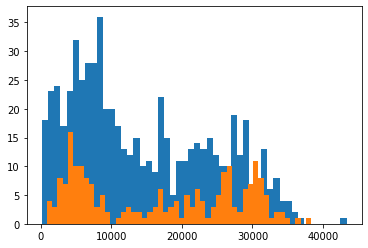

In [20]:
plt.hist(y_train2, bins=50);
plt.hist(y_val2, bins=50);

In [0]:
gkf = GroupKFold(n_splits=2)

# gkf.split()

## Model Building

### Model 1-segment

#### Bayesian Opt.

In [0]:
from bayes_opt import BayesianOptimization

def bayes_parameter_opt_lgb(X, y, init_round=15, opt_round=25, n_folds=5, random_seed=26, n_estimators=1500, learning_rate=0.02, output_logs=False):
    
    # prepare data
    train_data = lgb.Dataset(data=X, label=y)
    # parameters
    def lgb_eval(num_leaves, feature_fraction, bagging_fraction, max_depth):
        # lambda_l1, lambda_l2, min_split_gain, min_child_weight
        params = {'application':'regression_l1','num_iterations': n_estimators, 
                  'learning_rate':learning_rate, 'early_stopping_round':50, 'metric':'mape'}
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        # params['lambda_l1'] = max(lambda_l1, 0)
        # params['lambda_l2'] = max(lambda_l2, 0)
        # params['min_split_gain'] = min_split_gain
        # params['min_child_weight'] = min_child_weight

        cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =200, metrics=['mape'])
        # return max(cv_result['mape-mean'])
        return cv_result, max(cv_result)

    # range 
    lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (24, 45),
                                            'feature_fraction': (0.5, 0.9),
                                            'bagging_fraction': (0.8, 1.0),
                                            'max_depth': (5, 9),
                                            # 'lambda_l1': (0, 5),
                                            # 'lambda_l2': (0, 3),
                                            # 'min_split_gain': (0.001, 0.1),
                                            # 'min_child_weight': (5, 50)}, 
                                 random_state=0)
    # optimize
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    # output optimization process
    if output_logs==True: lgbBO.points_to_csv("bayes_opt_result.csv")
    
    # return best parameters
    return lgbBO.res['max']['max_params']


if BAYES_OPT:
    opt_time = time.time()
    
    opt_params = bayes_parameter_opt_lgb(train_x, train_y, init_round=5, opt_round=10, n_folds=3, 
                                     random_seed=6, n_estimators=1500, learning_rate=0.02)
    
    print('LGBM hyperparm tuning with Bayes Optimization:', opt_params)
    print('Optimization duration:', time.time()-opt_time, '[sec]')
    print('Optimization duration:', (time.time()-opt_time)/60, '[min]')

#### Randomized GS

In [0]:
SEED = 42
SCORE = 'r2'
# 'neg_mean_squared_error'   
# 'neg_median_absolute_error', 'neg_log_loss'  'neg_mean_absolute_error' 'r2'


N_FOLDS = 6


params = {"n_estimators":list(range(10,300,30)),
          "max_features":[0.5,'sqrt','log2',None],
          "max_depth":[3,4,5,6,7],
          "min_samples_leaf":[2,3,5,7,10]}


In [49]:
model1 = RandomForestRegressor(n_jobs=1, random_state=SEED)

rs1_time = time.time()

gkf = GroupKFold(n_splits=N_FOLDS).split(df1[feats], df1[target], groups=df1.month)
print('GroupKFold by month - # splits:', N_FOLDS)
print()

rscv1 = RandomizedSearchCV(estimator=model1, param_distributions=params,  cv=gkf,
                          n_iter=50, scoring=SCORE, random_state=42, verbose=1)

rscv1.fit(df1[feats], df1[target])

print('Random GS-1 elapsed time:', time.time()-rs1_time, '[sec]')
print('Random GS-1 elapsed time:', (time.time()-rs1_time)/60, '[min]')
print('--'*10)
print('best params:\n', rscv1.best_params_)
print('best_score', rscv1.best_score_.round(4))

GroupKFold by month - # splits: 2

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   18.5s finished


Random GS-1 elapsed time: 18.824257135391235 [sec]
Random GS-1 elapsed time: 0.3137504498163859 [min]
--------------------
best params:
 {'n_estimators': 190, 'min_samples_leaf': 7, 'max_features': None, 'max_depth': 7}
best_score 0.4289


In [0]:
# run1: 2 Folds 
# best params:{'n_estimators': 190, 'min_samples_leaf': 7, 'max_features': None, 'max_depth': 7}
# best_score 0.4289

# run2: 4 Folds 
# best params: {'n_estimators': 40, 'min_samples_leaf': 2, 'max_features': 0.5, 'max_depth': 6}
# best_score 0.41539856418736243

# run3: 3 Folds 
# best params: {'n_estimators': 40, 'min_samples_leaf': 3, 'max_features': 0.5, 'max_depth': 5}
# best_score 0.4421

# run4: 6 Folds 
# best params:{'n_estimators': 280, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 7}
# best_score 0.4461

In [0]:
model1_rs = rscv1.best_estimator_

In [51]:
y_pred1 = model1_rs.predict(x_val1)

mape_segment_1 = mape2(y_val1, y_pred1)
print('MAPE segment 1:', mape_segment_1)

MAPE segment 1: 16.00258793592423


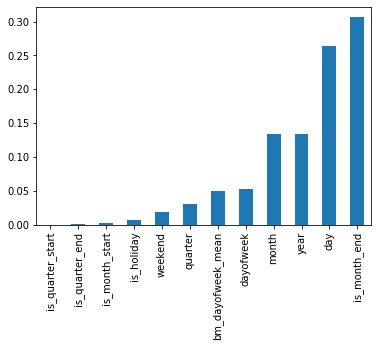

In [52]:
# feature importance Model-1
pd.Series(model1_rs.feature_importances_, feats).sort_values().plot(kind='bar')

### Model 2-segment

In [66]:
model2 = RandomForestRegressor(n_jobs=1, random_state=SEED)

rs2_time = time.time()

N_FOLDS = 6
gkf = GroupKFold(n_splits=N_FOLDS).split(df2[feats], df2[target], groups=df2.month)
print('GroupKFold by month - # splits:', N_FOLDS)
print()


rscv2 = RandomizedSearchCV(estimator=model2, param_distributions=params, cv=gkf, 
                           n_iter=50, scoring=SCORE, random_state=SEED, verbose=1)

rscv2.fit(df2[feats], df2[target])

print()
print('Random GS-2 elapsed time:', time.time()-rs2_time, '[sec]')
print('Random GS-2 elapsed time:', (time.time()-rs2_time)/60, '[min]')
print('--'*10)
print('best params:\n', rscv2.best_params_)
print('best_score', rscv2.best_score_.round(4))

GroupKFold by month - # splits: 6

Fitting 6 folds for each of 50 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Random GS-2 elapsed time: 59.55092191696167 [sec]
Random GS-2 elapsed time: 0.9925265630086263 [min]
--------------------
best params:
 {'n_estimators': 40, 'min_samples_leaf': 3, 'max_features': None, 'max_depth': 6}
best_score 0.8544


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   59.5s finished


In [67]:
model2_rs = rscv2.best_estimator_

model2_rs

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=6, max_features=None, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=40, n_jobs=1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [68]:
y_pred2 = model2_rs.predict(x_val2)

mape_segment_2 = mape2(y_val2, y_pred2)
print('MAPE segment 2:', mape_segment_2)

MAPE segment 2: 14.92020381446709


In [69]:
mape2(y_val2, y_pred2*1.01)

14.842866512422603

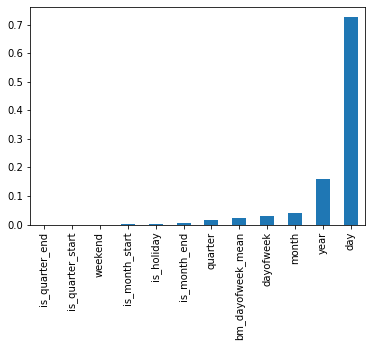

In [70]:
# feature importance Model-2
pd.Series(model2_rs.feature_importances_, feats).sort_values().plot(kind='bar')

### Total MAPE

In [71]:
total_mape = 0.5*mape_segment_1 + 0.5*mape_segment_2
print('MAPE:', total_mape.round(5))

MAPE: 15.4614


## Predict Test data

In [73]:
## process test data
data_test = process_date_data(data_test)
process_categ_data(data_test, categ_feats)

data_test = data_test.merge(bm, right_index=True, left_on=bm_cols, how='left')

print(data_test.dtypes)
data_test[feats].head()

id                            int64
application_date     datetime64[ns]
segment                       int64
year                       category
month                      category
dayofweek                     int64
day                        category
quarter                    category
is_month_start                int64
is_month_end                  int64
is_quarter_start              int64
is_quarter_end                int64
weekend                       int64
is_holiday                    int64
bm_dayofweek_mean           float64
dtype: object


,year,month,dayofweek,day,quarter,is_month_start,is_month_end,is_quarter_start,is_quarter_end,weekend,is_holiday,bm_dayofweek_mean
0,2019,7,5,6,3,0,0,0,0,1,0,2500.438596
1,2019,7,6,7,3,0,0,0,0,1,0,1599.846847
2,2019,7,0,8,3,0,0,0,0,0,0,3220.732759
3,2019,7,1,9,3,0,0,0,0,0,0,2782.836207
4,2019,7,2,10,3,0,0,0,0,0,0,3229.155172


In [74]:
# split by segment
data_test1 = data_test[data_test['segment'] == 1]
data_test2 = data_test[data_test['segment'] == 2]

data_test1[feats].shape, data_test2[feats].shape

((87, 12), (93, 12))

In [0]:
# segment-1 test predictions
test_preds1 = model1_rs.predict(data_test1[feats])

In [0]:
# segment-2 test predictions
test_preds2 = model2_rs.predict(data_test2[feats])

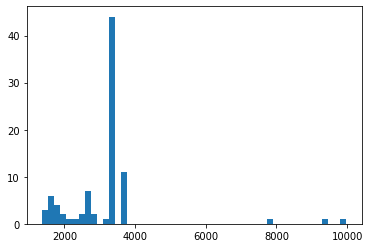

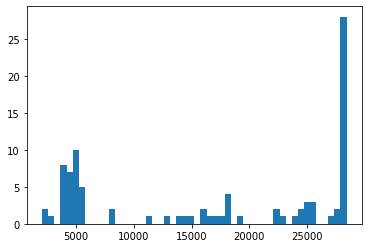

In [77]:
# histogram
plt.figure()
plt.hist(test_preds1, bins=50);
# plt.plot(test_preds1)
plt.figure()
plt.hist(test_preds2, bins=50);
# plt.plot(test_preds2)

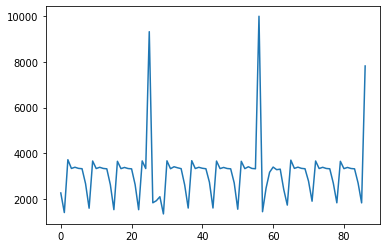

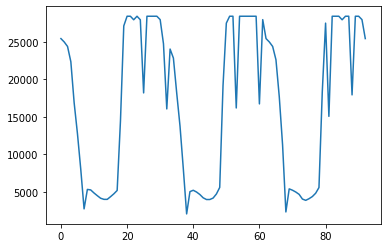

In [78]:
plt.figure()
plt.plot(test_preds1)
plt.figure()
plt.plot(test_preds2)

## Submission

In [79]:
subm_file.head()

,id,application_date,segment,case_count
0,1,2019-07-06,1,5
1,2,2019-07-07,1,5
2,3,2019-07-08,1,5
3,4,2019-07-09,1,5
4,5,2019-07-10,1,5


In [0]:
subm_file.loc[subm_file['segment'] == 1, 'case_count'] = test_preds1
subm_file.loc[subm_file['segment'] == 2, 'case_count'] = test_preds2

subm_file['case_count'] = subm_file['case_count'].astype(int)

In [0]:
out_name = out_path + 'LTFS_RF_by_segment_rscv_12feats_240120'
subm_file.to_csv((('%s.csv') % (out_name)), index=False)

# CV: 16.229   LB: 18.313

In [82]:
total_mape

15.46139587519566

## Explore wrt previous best submissions

In [83]:
best_subm1 = pd.read_csv(out_path+'best_git_subm1.csv')
best_subm2 = pd.read_csv(out_path+'best_git_subm2.csv')

best_subm1.shape, best_subm2.shape, subm_file.shape

((180, 4), (180, 4), (180, 4))

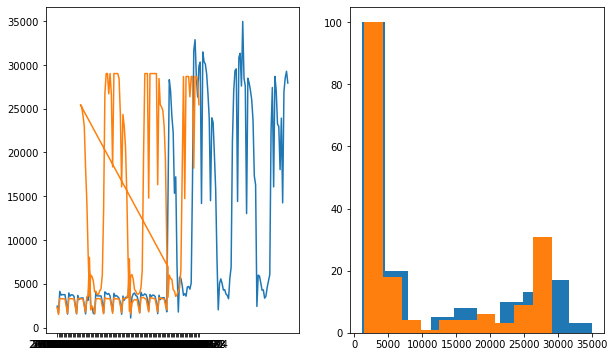

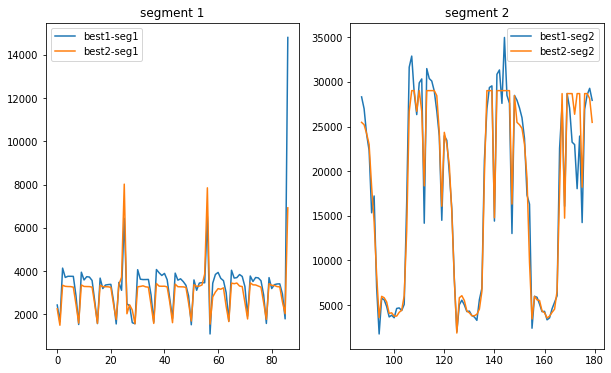

In [0]:
fig, ax = plt.subplots(1,2, figsize=(10,6))
ax[0].plot(best_subm1.case_count, label='best1')
ax[0].plot(best_subm2.application_date, best_subm2.case_count, label='best2')
ax[1].hist(best_subm1.case_count, label='best1')
ax[1].hist(best_subm2.case_count, label='best2')

# plot per segment values
fig, ax = plt.subplots(1,2, figsize=(10,6))
ax[0].plot(best_subm1.loc[best_subm1.segment==1, 'case_count'], label='best1-seg1')
ax[0].plot(best_subm2.loc[best_subm2.segment==1, 'case_count'], label='best2-seg1')
ax[0].set_title('segment 1')
ax[0].legend()
ax[1].plot(best_subm1.loc[best_subm1.segment==2, 'case_count'], label='best1-seg2')
ax[1].plot(best_subm2.loc[best_subm2.segment==2, 'case_count'], label='best2-seg2')
ax[1].set_title('segment 2')
ax[1].legend()


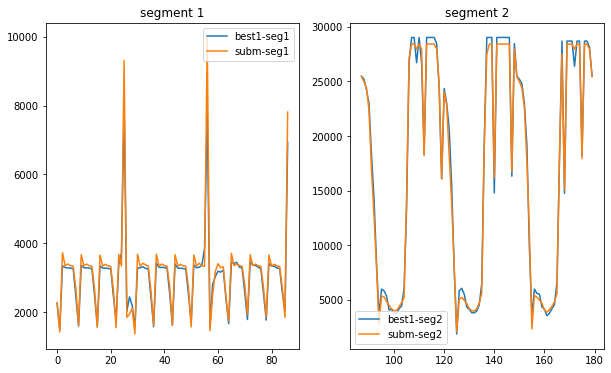

In [84]:
fig, ax = plt.subplots(1,2, figsize=(10,6))
ax[0].plot(best_subm2.loc[best_subm2.segment==1, 'case_count'], label='best1-seg1')
ax[0].plot(subm_file.loc[subm_file.segment==1, 'case_count'], label='subm-seg1')
ax[0].set_title('segment 1')
ax[0].legend()
ax[1].plot(best_subm2.loc[best_subm2.segment==2, 'case_count'], label='best1-seg2')
ax[1].plot(subm_file.loc[subm_file.segment==2, 'case_count'], label='subm-seg2')
ax[1].set_title('segment 2')
ax[1].legend()


## Ensemble submissions

In [0]:
def ensemble_submissions(df1, df2, weights=[0.2, 0.8]):
    subm_file = pd.read_csv(data_path+'LTFS_sample_submission.csv')
    subm_file[target] = (df1.case_count*weights[0] + df2.case_count*weights[1])
    return subm_file

# df1 = subm_file.copy() # pd.read_csv("xxx.csv")
df2 = pd.read_csv(out_path+'best_git_subm1.csv')    # current best submission
out_name = out_path + 'subm_ensemble_rf_weighted_240120'

subm_file = ensemble_submissions(subm_file, df2)
subm_file.to_csv((('%s.csv') % (out_name)), index=False)

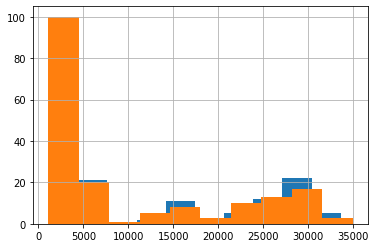

In [86]:
subm_file.case_count.hist()
best_subm1.case_count.hist()

In [0]:
# LB: 15.525

In [0]:
# save models to pickle
import pickle

model_path1 = models_path + 'model_seg1_rf_rscv_240120.pkl'
model_path2 = models_path + 'model_seg2_rf_rscv_240120.pkl'

with open(model_path1, 'wb') as f:
    pickle.dump(model1_rs, f)

with open(model_path2, 'wb') as f:
    pickle.dump(model2_rs, f)